# Introduction  
This notebook demonstrates how to use the new Studies support added to Sedaro. 
The core of this support is the new API python client object **SimStudy**.
**SimStudy** will generate and run a series of *SimJobs* in parallel up to account capacity limits. The remaining simjobs will be placed in a queue and will be execute when resources are available. 

Each *SimJob* of a **SimStudy** will set the random seed to a different value in order to generate different output results from the simulation.
The **Overrides** feature takes this a step further by providing a means to adjust any starting value of any model of the simulation using a set of pre-defined functions. In other words, each *SimJob* of a **SimStudy** will run a baseline Scenario branch with model parameters variations in order to observe their effects on performance results.

# Setup
Running this notebook requires the following:
- A Sedaro Account            --> https://www.sedaro.com
- A Sedaro API Token          --> https://www.sedaro.com/#/account
- The Wildfire Demo Branch ID --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire Scenarios --> copy main branch ID via clipboard icon (TODO insert screen shot)
- Python 3.10+ installed      --> https://www.python.org
- Jupyter notebook or lab     --> https://jupyter.org

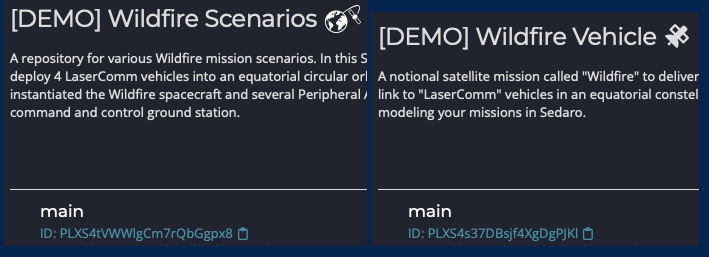

## Pip requirements
Create/activate a python venv if desired

In [1]:
#!python -m venv /path/to/new/virtual/environment

Activate it via this table
| Platform | Shell | Command to activate virtual environment |
| :- | :- | :- |
| POSIX | bash/zsh |  source <venv>/bin/activate |
| | fish |  source <venv>/bin/activate.fish |
| | csh/tcsh |  source <venv>/bin/activate.csh |
| | PowerShell |  <venv>/bin/Activate.ps1 |
| Windows | cmd.exe | C:\> <venv>\Scripts\activate.bat |
| | PowerShell | PS C:\> <venv>\Scripts\Activate.ps1 |

Required python modules:
> replace *python* with *python3* if needed 

In [2]:
#!python -m pip install -e sedaro pytest matplotlib pandas sweetviz msgpack

or

In [3]:
#!python3.10 -m pip install  sedaro pytest matplotlib pandas sweetviz msgpack

In [4]:
#!python3.10 -m pip install sweetviz IProgress

Run the following cells to test if all required python modules are installed correctly

Optional module needed by the stats() function if desired 

In [5]:
import sedaro
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import utils

In [6]:
# optional
import sweetviz as sv

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.



## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [7]:
Sedaro_api_host  = "http://localhost:80" # "api.sedaro.com"

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_KEY']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

## Load the wildfire scenario branch data
Change the value of the *scenario_branch_id* and *wildfire_agent_branch_id* in the next cell to the branch id noted above during the **Setup** section.
then run the following cell:

In [8]:
scenario_branch_id = "<your_wildfire_scenario_branch_id>"
wildfire_scenario_branch = sedaroAPI.scenario(scenario_branch_id)

wildfire_agent_branch_id = "<your_wildfire_agent_branch_id>"
wildfire_agent_branch = sedaroAPI.agent_template(wildfire_agent_branch_id)

## Wildfire Tradespace Analysis: Battery Size vs. Mass effects on Agent maneuverability
The first study example will show the effects of Agent maneuverability, measured by the Wildfire Agent total in Field of view time to its ground stations, by the choice of battery size and weight. 



### Setup
Find or make a branch of the wildfire scenaro and record its branch ID value.



### Optional: Load shared workspace to skip setup and running the study
TODO - couldn't get python client to load data from shared workspace


#### Research
- Data sources: 
  - Spec sheets for satellite batteries (https://www.eaglepicher.com/markets/space/satellites/)

In particular:
- Primary Lithium-Ion Cells Space COTS Batteries Offerings from Eaglepicher
  - (https://www.eaglepicher.com/sites/default/files/COTS%201022.pdf):
  - 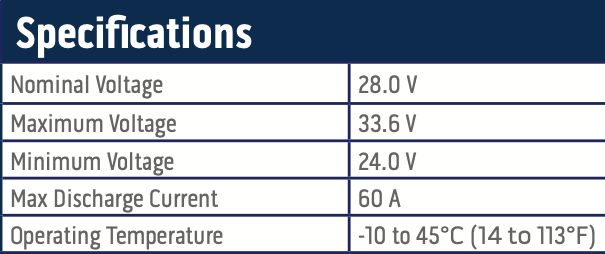
  
|  | Specifications |
| :-: | :-: |
| Nominal Voltage | 28.0 V |
| Maximum Voltage | 33.6 V |
| Minimum Voltage | 24.0 V |
| Max Discharge Current | 60 A |
| Operating Temperature | -10 to 45°C (14 to 113°F) |

  - 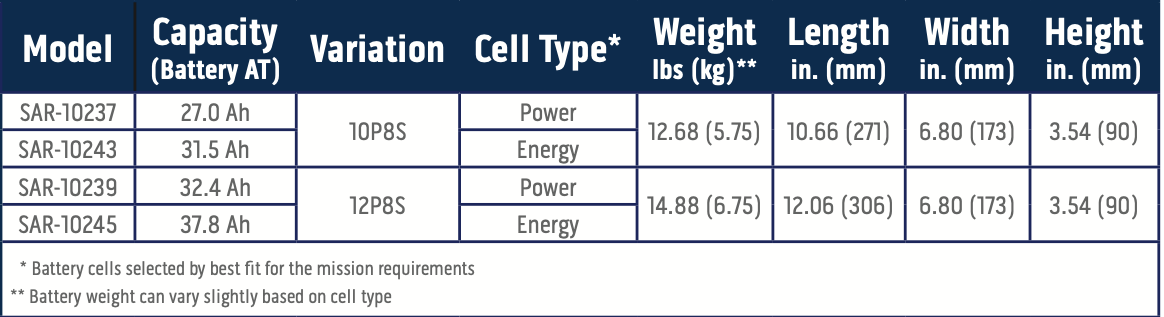
  
| Model | Capacity | Variation | Cell Type | Weight lbs(kgs) | Length in.(mm) | Width in. (mm) | Height in. (mm) | volume in^3 | 
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| SAR-10237 | 27.0 Ah | 10P8S | Power | 12.68 (5.75) | 10.66 (271)  | 6.8 (173) | 3.54 (90) | 256.607 |
| SAR-10243 | 31.5 Ah | | Energy |  | |
| |
| SAR-10239 | 32.4 Ah | 12P8S | Power | 14.88 (6.75) | 12.06 (306) | 6.8 (173) | 3.54 (90) | 303.3 |
| SAR-10243 | 31.5 Ah |  | Energy |  | |
| P33081    | 30 Ah   |  |  | 2.1 (0.950) |  5.985 (150) | 3.771(96) | 1.108 (28.1) | 25.00 |
| LP33330   |  6Ah    |  |  | 0.222    | 1.964     |   0.874   |  3.064 | 5.259 |


The LP33330 cell is the baseline cell in a 2 Parallel and 8 series arrangement (aka 16 cells total).
```
= ~ 24 to 32 volts
= 12Ah
= 0.222 * 16 --> 3.552 kg
= 5.259 * 16 --> 84.15 cubic in -->  1378.97144 Cubic cm of space used on the agent
```

```
SAR-10237 can fit 0.3279 cells in the space --> 1 cell adds 2.20 kg
SAR-10239 can fit 0.2774 cells in the space --> 1 cell adds 3.20 kg
P33081    can fit 3.366  cells in the space --> 3 cells removes 0.702 kg  
```



#### Deternmine Parameter Paths
Search for the model parameter paths to override using the path search function

In [9]:
from sedaro import AgentModelParametersOverridePaths

wildfire_agent_paths = AgentModelParametersOverridePaths(wildfire_scenario_branch, wildfire_agent_branch, agent_name='Wildfire')


Lets look for mass and Dry Inerta X.X, Y.Y, and Z.Z Paths on the wildfire agent

In [ ]:
wildfire_agent_paths.findBestPathMatch("mass")

In [ ]:
wildfire_agent_paths.findPathMatches("inertia", 15)

Based on those search results, the parameter paths we'll use for this study are:
- 'Wildfire/data/mass'
- 'Wildfire/data/inertia/0/0'
- 'Wildfire/data/inertia/1/1'
- 'Wildfire/data/inertia/2/2'


#### Create tradespace table 
Model SAR-10237: **Volume** = 271 * 173 * 90 --> 4.21947 cm^3  / **Mass** (5.750 kg) --> **Density** = 1362.7303903097  kg/m3
Mass times number of cells  = 5.750 kg * 10 = 


Model SAR-10239: **Volume** = 306 * 173 * 90 --> 4.7642 cm^3 / **Mass** (6.750 kg)  --> **Density** = 1416.751671767  kg/m3
Mass times number of cells  = 6.750 kg * 10 = 


Model P33081: **Volume** = in 150 * 96 * 28.1 --> .40464 cm^3  / **Mass** (950 g)   --> **Density** = 2347.7659153816 kg/m3
Mass times number of cells  = 6.750 kg * 10 = 


| Agent Parameter | Sim LP33330 Baseline | Sim SAR-10237 Value | Sim SAR-10239 Value | Sim P33081 Value | Parameter Path | Agent_ID_PATH |
| :-: | :-: | :-: | :-: | :-: | :-: |:-: |
| Battery pack mass(kg) | 3.552 | 5.750 | 6.750 | 2.850 | /Wildfire/data/mass | 'NT06aqHUT5djI1_JPAsck.data.mass' |
| Dry Inertia(kg m^2) X.X | 270.0 | (A) | (A) | (A) | /Wildfire/data/inertia/0/0 | 'NT06aqHUT5djI1_JPAsck.data.inertia.0.0' |
| Dry Inertia(kg m^2) Y.Y | 420.0 | (B) | (B) | (B) | /Wildfire/data/inertia/1/1 | 'NT06aqHUT5djI1_JPAsck.data.inertia.1.1' |
| Dry Inertia(kg m^2) Z.Z | 520.0 | (C) | (C) | (C) | /Wildfire/data/inertia/2/2 | 'NT06aqHUT5djI1_JPAsck.data.inertia.2.2' |

(A) Dry Inerta X.X = original/mass * delta + original

(B) Dry Inerta Y.Y = original/mass * delta + original

(C) Dry Inerta Z.Z = original/mass * delta + original

The paths we will be modifying will be:
- **'NT06aqHUT5djI1_JPAsck.data.mass'**: 1000.0,
    - */Wildfire/data/mass*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.0.0'**: 270.0,
    - *Wildfire/data/inertia/0/0*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.0.1'**: 0.0,
    - *Wildfire/data/inertia/0/1*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.0.2'**: 0.0,
    - *Wildfire/data/inertia/0/2*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.1.0'**: 0.0,
    - *Wildfire/data/inertia/1/0*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.1.1'**: 420.0,
    - *Wildfire/data/inertia/1/1*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.1.2'**: 0.0,
    - *Wildfire/data/inertia/1/2*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.2.0'**: 0.0,
    - *Wildfire/data/inertia/2/0*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.2.1'**: 0.0,
    - *Wildfire/data/inertia/2/1*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.2.2'**: 520.0,
    - *Wildfire/data/inertia/2/2*


#### Overrides used
We will use the sim_index override to run the above tradespace table:

In [10]:
tradespace_overrides_dict = {
  "name": "Tradespace Example",
  "variables": [
    {
      "name": "Baseline_mass",
      "path": "Wildfire/root/mass"
    },
    {
      "name": "SAR-10237_mass_delta",
      "equals": 2.20
    },
    {
      "name": "SAR-10239_mass_delta",
      "equals": 3.20
    },
    {
      "name": "P33081_mass_delta",
      "equals": -0.702
    },
    {
      "name": "Baseline_dry_inertia_X.X",
      "path": "Wildfire/root/inertia/0/0"
    },
    {
      "name": "Baseline_dry_inertia_Y.Y",
      "path": "Wildfire/root/inertia/1/1"
    },
    {
      "name": "Baseline_dry_inertia_Z.Z",
      "path": "Wildfire/root/inertia/2/2"
    }
  ],
  "overrides": [
    {
      "path": "Wildfire/root/mass",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_mass"}, 
                      {"fn": "+", "arg": "SAR-10237_mass_delta"}, 
                      {"fn": "+", "arg": "SAR-10239_mass_delta"}, 
                      {"fn": "+", "arg": "P33081_mass_delta"}, 
                  ]
    },
    {
      "agent_key": "NT06aqHUT5djI1_JPAsck.data.inertia.0.0",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_dry_inertia_X.X"}, 
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10237_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_X.X" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10239_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_X.X" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "P33081_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_X.X" } ] 
                      },
                  ]
    },
    {
      "agent_key": "NT06aqHUT5djI1_JPAsck.data.inertia.1.1",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_dry_inertia_Y.Y"}, 
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10237_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Y.Y" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10239_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Y.Y" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "P33081_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Y.Y" } ] 
                      },
                  ]
    },
    {
      "agent_key": "NT06aqHUT5djI1_JPAsck.data.inertia.2.2",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_dry_inertia_Z.Z"}, 
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10237_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Z.Z" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10239_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Z.Z" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "P33081_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Z.Z" } ] 
                      },
                  ]
    },
  ]
}

uncomment the following cell if this is the first time running this notebook

In [11]:
#tradespace_overrides_block = wildfire_scenario_branch.OverrideSet.create(**tradespace_overrides_dict)


or just reload the one you previously created

In [12]:
#tradespace_overrides_block = (wildfire_scenario_branch.OverrideSet.get_first())

In [13]:
tradespace_overrides_block


OverrideSet(
   disabled=False
   id='PKghWNfbXwHLq8xBDPKsZg'
   name='Tradespace Example'
   overrides=[{'agent_key': None, 'path': 'Wildfire/data/mass', 'sim_index': [{'agent_key': None, 'arg': 'Baseline_mass', 'fn': '=', 'path': None}, {'agent_key': None, 'arg': 'SAR-10237_mass_delta', 'fn': '+', 'path': None}, {'agent_key': None, 'arg': 'SAR-10239_mass_delta', 'fn': '+', 'path': None}, {'agent_key': None, 'arg': 'P33081_mass_delta', 'fn': '+', 'path': None}]}, {'agent_key': 'NT06aqHUT5djI1_JPAsck.data.inertia.0.0', 'path': None, 'sim_index': [{'agent_key': None, 'arg': 'Baseline_dry_inertia_X.X', 'fn': '=', 'path': None}, {'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 'Baseline_mass', 'fn': '/', 'path': None}, {'agent_key': None, 'arg': 'SAR-10237_mass_delta', 'fn': '*', 'path': None}, {'agent_key': None, 'arg': 'Baseline_dry_inertia_X.X', 'fn': '+', 'path': None}], 'path': None}, {'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 'Baseline_mass', 'fn': '/', 

record the generated override block ID

In [14]:
tradespace_overrides_id = tradespace_overrides_block.id
# or you can use the id directly if you recorded it
# tradespace_overrides_id = "<your_tradespace_overrides_id>"

#### Create and Run Study 

In [ ]:
iterations = 2 # change to the desired number of iterations you want to run
new_studyjob = utils.runStudy(sedaroAPI, scenario_branch_id, iterations, tradespace_overrides_id)
new_studyjob

Get the status of all Studies in your workspace

In [16]:
utils.workspaceStudyJobStatus(sedaroAPI, scenario_branch_id)

In [17]:
#first_study = wildfire_scenario_branch.Study.get_first()
study_id = 'PKjwzmW99mRrRm4cmQGr7m' 
#study_id =  new_studyjob['id'] #
study_control_resource = f'/simulations/branches/{scenario_branch_id}/control/study/{study_id}'

### Check on Study Status

In [18]:
study_status = utils.getStudyStatus(sedaroAPI, scenario_branch_id, study_id)

In [19]:
study_status

{'branch': 'PKgBt4JWCmLVFBBzQBK3d8',
 'dateCreated': '2023-12-04T20:21:03.901Z',
 'dateModified': '2023-12-04T20:45:36.281Z',
 'id': 'PKjwzmW99mRrRm4cmQGr7m',
 'jobType': 'STUDY',
 'jobs': ['PKjwzrMWQv3Sm6mYKThbtK',
  'PKhJQ76WN3HvyN4JXjl4Kw',
  'PKhGtfzBcvLh6qPtdBylJ5',
  'PKgkfrXdHLYRslCZkvSy9m'],
 'message': 'Started study successfully.',
 'predecessor': None,
 'scenarioHash': 'c5f44bbf7ed3d88f81d398a367b364afe863a32fc49aad37d30f279ae51a24bd',
 'status': 'SUCCEEDED',
 'successors': [],
 'workspace': 'PKgBsyk48JVMJcL59yvcWM'}

In [20]:
study_job_ids = study_status['jobs']

To see all the status of the simuation jobs in the study run the following cell.
Note: SimulationJobs in the queued state will run once simulation resources are available to do so.

In [21]:
utils.getStudySimJobsStatus(sedaroAPI, scenario_branch_id, study_id)

[('SimJob ID: PKjwzrMWQv3Sm6mYKThbtK',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKhJQ76WN3HvyN4JXjl4Kw',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKhGtfzBcvLh6qPtdBylJ5',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKgkfrXdHLYRslCZkvSy9m',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100})]

Or you can view the scenario branch on the Web client to see the Study Simulation Jobs status by clicking the **'View Jobs'** button 

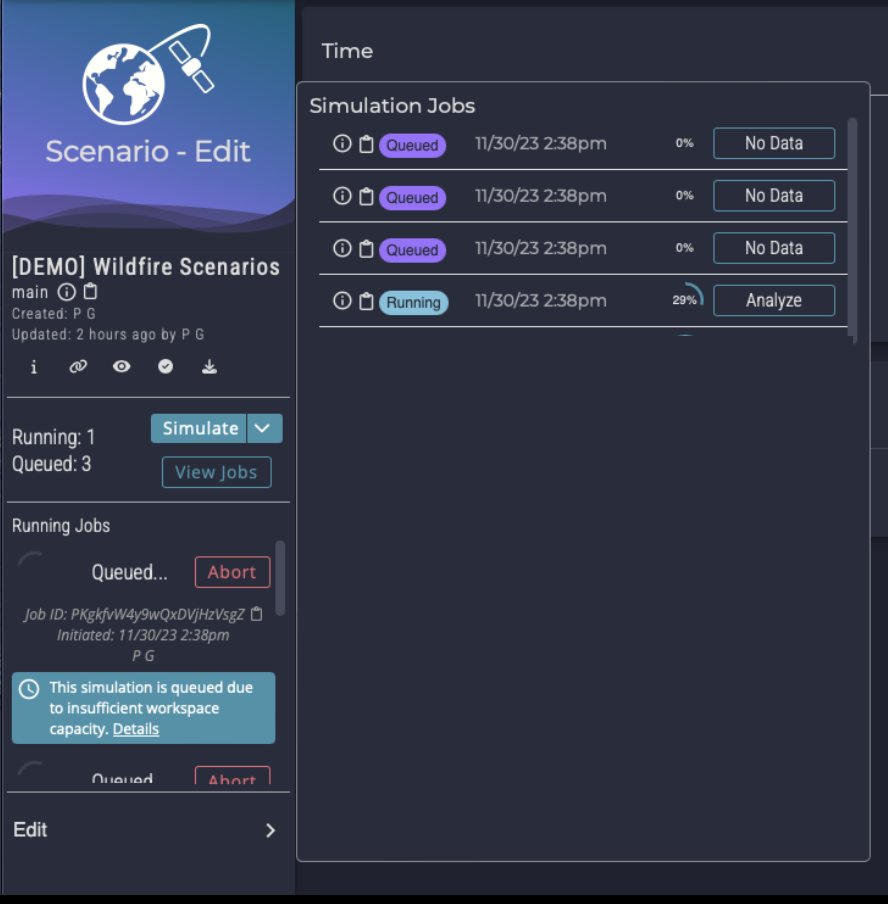


Once any of the simulation jobs have finished, you can examine the results while waiting for the other to complete. 

### Load the results of the Study SimJobs
Load the the Study Results then load the result data from all of its  simulation set. We'll reduce the data set to 1000 points each for this example.

In [22]:
study_job = wildfire_scenario_branch.study.results(study_status['id'])

In [23]:
# some helper variables
agent_id='NT06aqHUT5djI1_JPAsck' 
engine_name='GNC' 
agent_name='Wildfire'

In [24]:
study_job.job_ids

['PKjwzrMWQv3Sm6mYKThbtK',
 'PKhJQ76WN3HvyN4JXjl4Kw',
 'PKhGtfzBcvLh6qPtdBylJ5',
 'PKgkfrXdHLYRslCZkvSy9m']

In [25]:
study_job.summarize()

---------------------------------------------------------------------------
                        Sedaro Study Result Summary                        
                       Job ID PKjwzmW99mRrRm4cmQGr7m                       
---------------------------------------------------------------------------
✅ Study succeeded

📋 Study contains 4 simulations

 ['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m']

❗ In-memory simulation result caching is ON
---------------------------------------------------------------------------
❓ Agent data not yet loaded. Load with .summarize_agents()
---------------------------------------------------------------------------
❓ First set desired results downsampling with:
       .set_result_limit(<# of points>) 
       .set_result_binWidth( <fraction of overall points> )   
---------------------------------------------------------------------------
❓ Query individual simulation results with .sim_result(<

In [ ]:
study_job.summarize_agents()

### Analyze Study results
First lets take a look at attitudeError on the Wildfire agent root block

In [27]:
study_Wildfire_agents = study_job.agents('Wildfire')

In [28]:
study_Wildfire_agents.summarize()


---------------------------------------------------------------------------
                         Study Agent Result Summary                        
                                 'Wildfire'                                
                     Study ID: 'PKjwzmW99mRrRm4cmQGr7m'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m']
---------------------------------------------------------------------------
🧩 Study Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📦 Available Blocks
    ----------------------------------------------------------
    |                  id                         name       |
    ----------------------------------------------------------
    | root                      

In [29]:
study_Wildfire_agents.blocks("root").summarize()

---------------------------------------------------------------------------
                   Study Simulation Block Result Summary                   
                                   'root'                                  
                     Study ID: 'PKjwzmW99mRrRm4cmQGr7m'                    
---------------------------------------------------------------------------
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m']
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📋 Variables Available
    • torque
    • velocity
    • srpTorque
    • dragTorque
    • position
    • attitudeError
    • controlTorque
    • attitudeSolution
    • pos

In [ ]:
study_Wildfire_agents.blocks("root").study_stats()

Looking at the available variables available on the Agent Root block, lets examine the changes to *Attitude Error* between the simulations. Each entry iss a list of [rool, pitch, yaw] in radians. 

In [30]:
study_Wildfire_agents.blocks("root").attitudeError.summarize()

---------------------------------------------------------------------------
                   Study Simulation Series Result Summary                  
                              'attitudeError'                              
                     Study ID: 'PKjwzmW99mRrRm4cmQGr7m'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m']
---------------------------------------------------------------------------
                    Study Simulation Series Data Summary                   
                              'attitudeError'                              
---------------------------------------------------------------------------
📈 sim_id:PKjwzrMWQv3Sm6mYKThbtK 1000 points covering 494.0 minutes with ~29.6s steps
📈 sim_id:PKhJQ76WN3HvyN4JXjl4Kw 1000 points cove

Reminder, Sim Tradespace is 


|'PKjwzrMWQv3Sm6mYKThbtK'| 'PKhJQ76WN3HvyN4JXjl4Kw'| 'PKhGtfzBcvLh6qPtdBylJ5'| 'PKgkfrXdHLYRslCZkvSy9m' |
| --- |--- |--- |--- |
|  LP33330 Baseline |  SAR-10237  |  SAR-10239  |  P33081  |

Due to the data type being a list, a list of roll-pitch-yaw radians in this case, we'll use the study sub_plots feature 

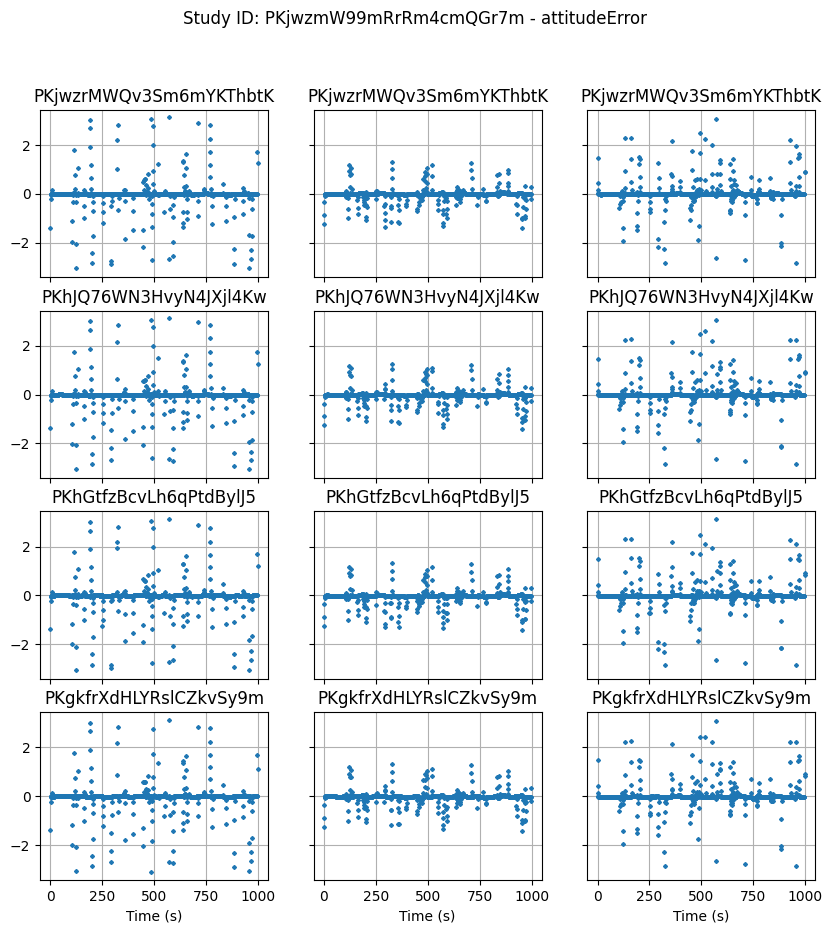

In [31]:
study_Wildfire_agents.blocks("root").attitudeError.study_subplots(cols=3)


We can look at the histograms of the roll pitch yaw of all the study simulations. 

Note (Radians): 
- attitudeError.0 = Roll 
- attitudeError.1 = Pitch
- attitudeError.2 = Yaw

array([[<Axes: title={'center': "('PKjwzrMWQv3Sm6mYKThbtK', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKjwzrMWQv3Sm6mYKThbtK', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKjwzrMWQv3Sm6mYKThbtK', 'attitudeError.2')"}>],
       [<Axes: title={'center': "('PKhJQ76WN3HvyN4JXjl4Kw', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKhJQ76WN3HvyN4JXjl4Kw', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKhJQ76WN3HvyN4JXjl4Kw', 'attitudeError.2')"}>],
       [<Axes: title={'center': "('PKhGtfzBcvLh6qPtdBylJ5', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKhGtfzBcvLh6qPtdBylJ5', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKhGtfzBcvLh6qPtdBylJ5', 'attitudeError.2')"}>],
       [<Axes: title={'center': "('PKgkfrXdHLYRslCZkvSy9m', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKgkfrXdHLYRslCZkvSy9m', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKgkfrXdHLYRslCZkvSy9m', 'attitudeError.2')"}>]],

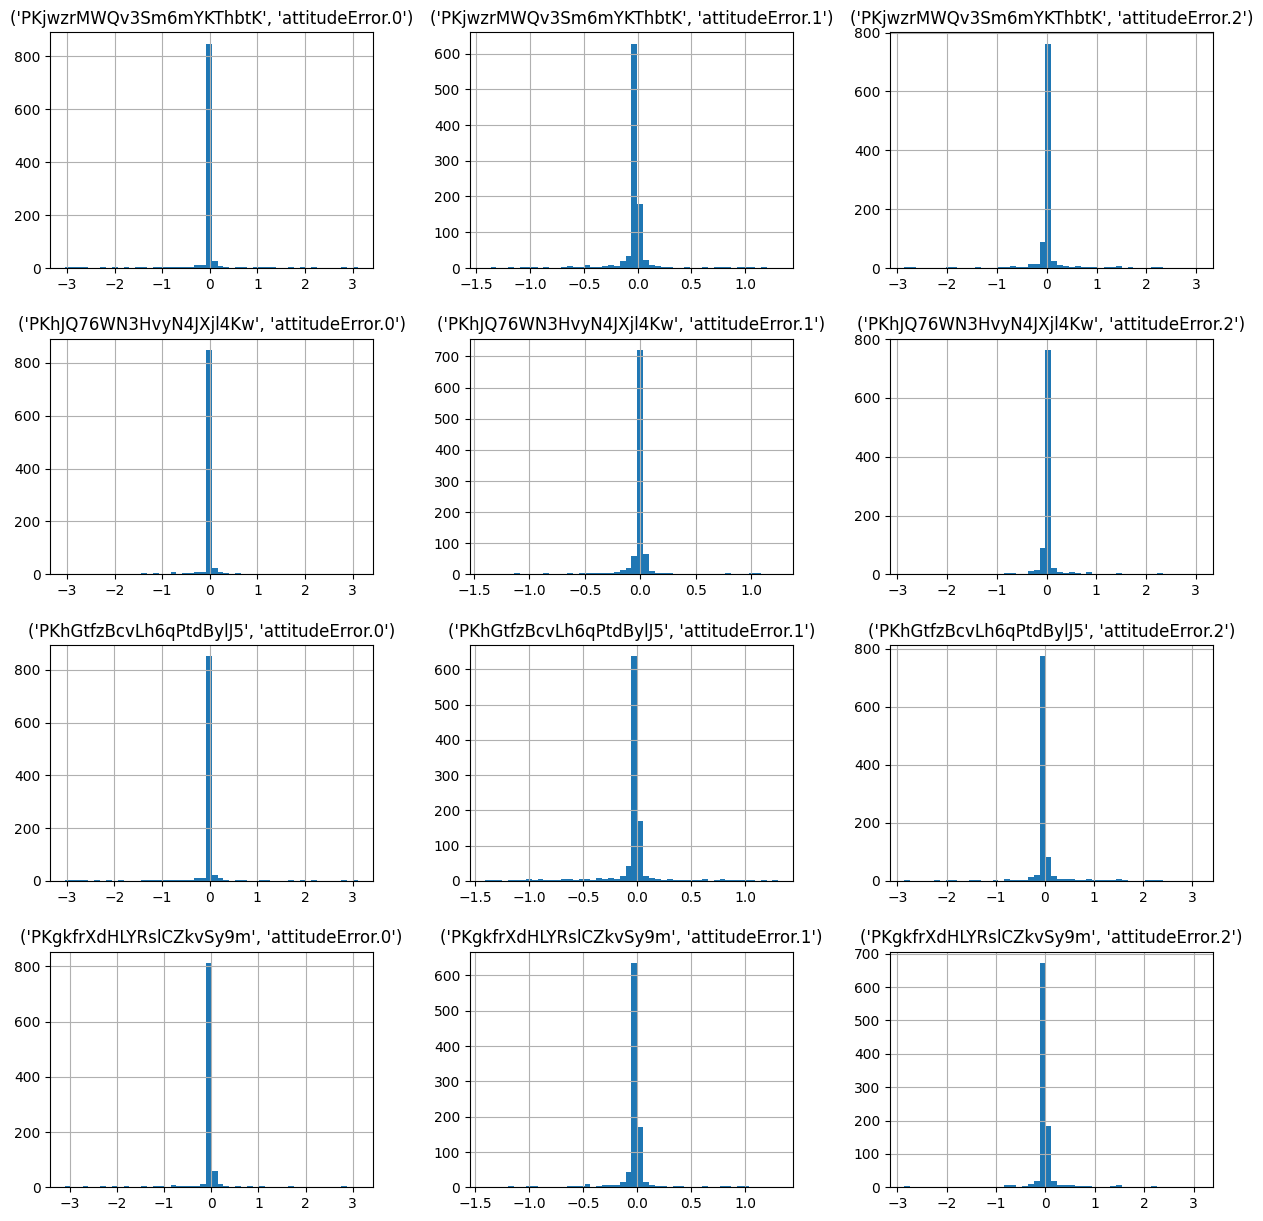

In [32]:
study_Wildfire_agents.blocks("root").attitudeError.study_histogram(size=15, bins=50)

And finally look how the attitude Error basic statistics compare against each simulation run

In [33]:
study_Wildfire_agents.blocks("root").attitudeError.study_stats()

count      mean       std       min   
PKjwzrMWQv3Sm6mYKThbtK attitudeError.0  999.0 -0.029148  0.518691 -3.042798  \
                       attitudeError.1  999.0 -0.025290  0.238541 -1.421243   
                       attitudeError.2  999.0  0.007253  0.419130 -2.854870   
PKhJQ76WN3HvyN4JXjl4Kw attitudeError.0  999.0 -0.031738  0.522620 -3.044003   
                       attitudeError.1  999.0 -0.020368  0.231197 -1.403003   
                       attitudeError.2  999.0  0.008327  0.417760 -2.856530   
PKhGtfzBcvLh6qPtdBylJ5 attitudeError.0  999.0 -0.028846  0.522901 -3.037756   
                       attitudeError.1  999.0 -0.025503  0.240353 -1.414298   
                       attitudeError.2  999.0  0.006952  0.426520 -2.856006   
PKgkfrXdHLYRslCZkvSy9m attitudeError.0  999.0 -0.036582  0.514280 -3.103202   
                       attitudeError.1  999.0 -0.020700  0.231167 -1.408989   
                       attitudeError.2  999.0  0.008063  0.414241 -2.854963   

                                             25%       50%       75%       max  
PKjwzrMWQv3Sm6mYKThbtK attitudeError.0 -0.014349 -0.003488 -0.000473  3.121786  
                       attitudeError.1 -0.014407 -0.008859 -0.004614  1.307353  
                       attitudeError.2 -0.017854 -0.015966  0.001056  3.038402  
PKhJQ76WN3HvyN4JXjl4Kw attitudeError.0 -0.014533 -0.003373 -0.000580  3.123206  
                       attitudeError.1 -0.013436 -0.008834 -0.002920  1.245555  
                       attitudeError.2 -0.017566 -0.015999  0.000718  3.045521  
PKhGtfzBcvLh6qPtdBylJ5 attitudeError.0 -0.014046 -0.003241 -0.000552  3.124569  
                       attitudeError.1 -0.014670 -0.009047 -0.004550  1.308999  
                       attitudeError.2 -0.017607 -0.015943  0.001075  3.113357  
PKgkfrXdHLYRslCZkvSy9m attitudeError.0 -0.014348 -0.003194 -0.000508  3.120662  
                       attitudeError.1 -0.013795 -0.008693 -0.002194  1.305868  
                       attitudeError.2 -0.018042 -0.016031  0.000594  3.089350

Finally, we can compare the attitude error values against each other with a scatter_matrix plot. We are interested in the intersection plot of 

roll <--> roll comparisions between the simulation runs
- PKjwzrMWQv3Sm6mYKThbtK	attitudeError.0
- PKhJQ76WN3HvyN4JXjl4Kw	attitudeError.0
- PKhGtfzBcvLh6qPtdBylJ5	attitudeError.0
- PKgkfrXdHLYRslCZkvSy9m	attitudeError.0

pitch <--> pitch 
- PKjwzrMWQv3Sm6mYKThbtK    attitudeError.1
- PKhJQ76WN3HvyN4JXjl4Kw    attitudeError.1
- PKhGtfzBcvLh6qPtdBylJ5    attitudeError.1
- PKgkfrXdHLYRslCZkvSy9m    attitudeError.1

yaw <--> yaw
- PKjwzrMWQv3Sm6mYKThbtK    attitudeError.2
- PKhJQ76WN3HvyN4JXjl4Kw    attitudeError.2
- PKhGtfzBcvLh6qPtdBylJ5    attitudeError.2
- PKgkfrXdHLYRslCZkvSy9m    attitudeError.2

Note the Diagonal is the KDE plot of the data stream

**Note** The following cells have output graphics that will change if they are re-run.  If they are re-run, you'll have to update ID values in the upcoming cells

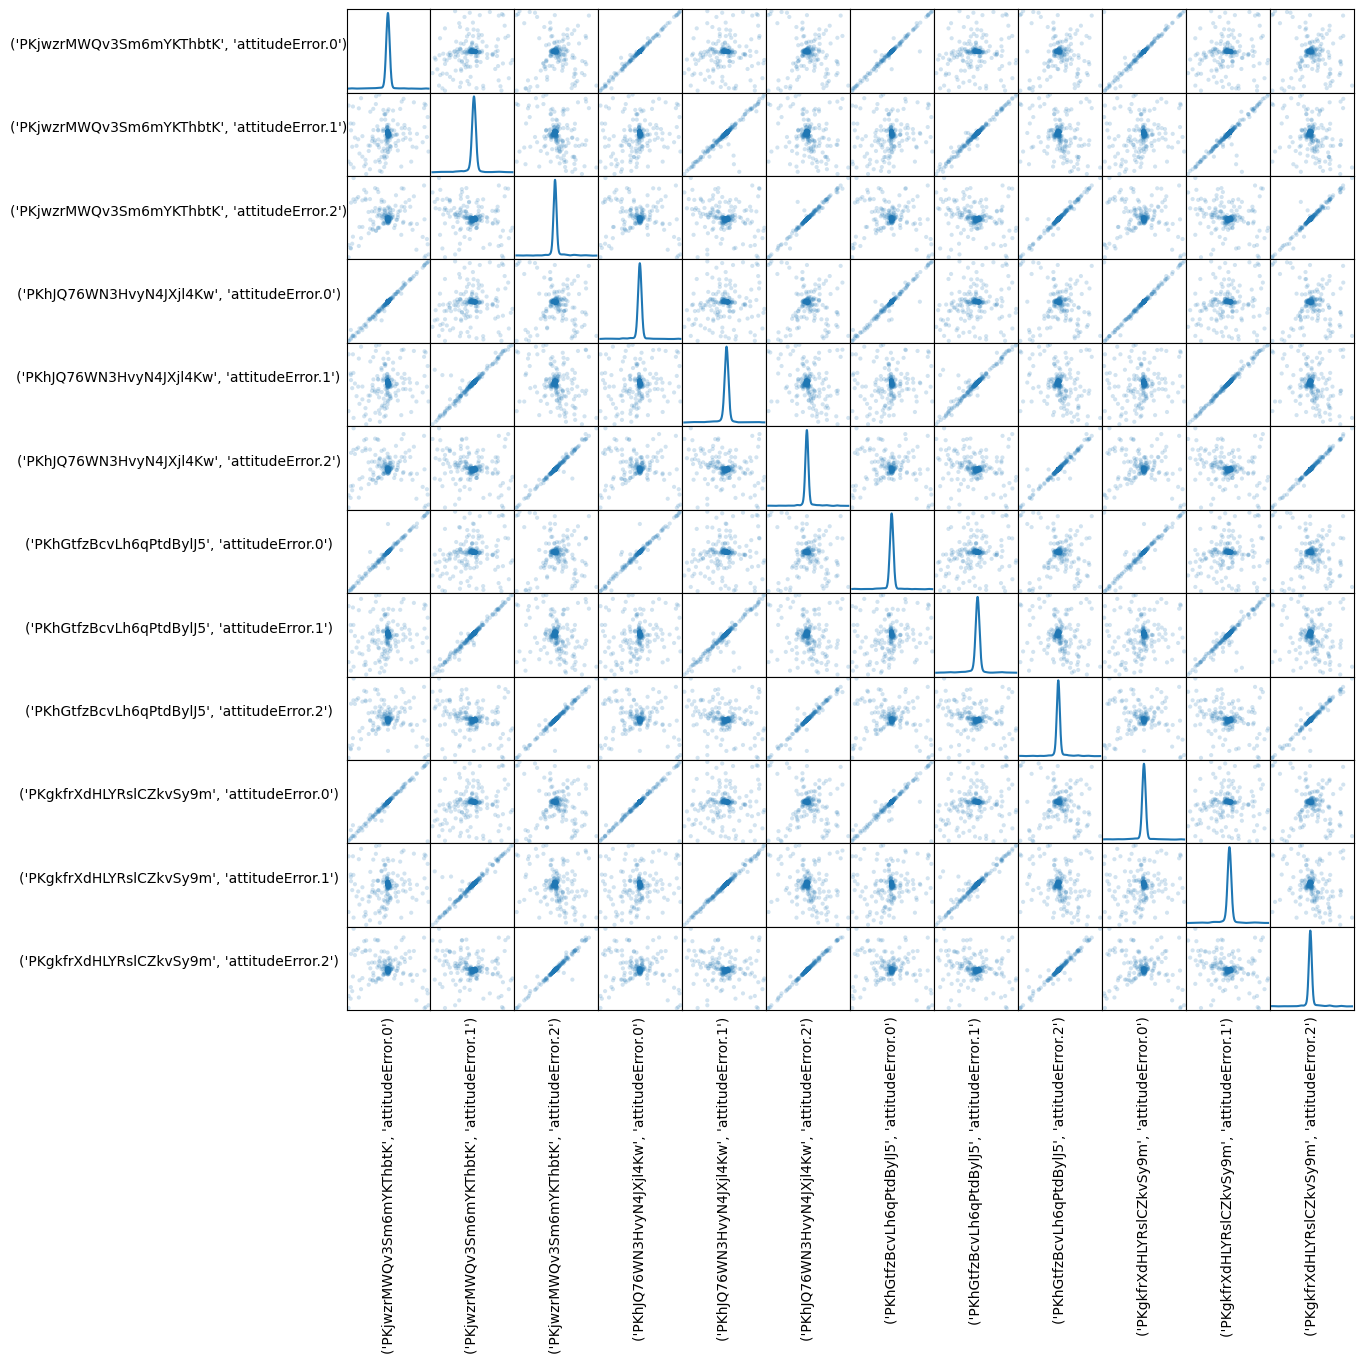

In [37]:
study_Wildfire_agents.blocks("root").attitudeError.study_scatter_matrix(size=13)

The scatter_matrix show a fairly linear releationship of the simulation roll, pitch yaw errors. However, Pitch has a some outliners between the simulation runs:


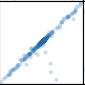  PKjwzrMWQv3Sm6mYKThbtK to PKhJQ76WN3HvyN4JXjl4Kw

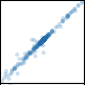 PKjwzrMWQv3Sm6mYKThbtK to PKhGtfzBcvLh6qPtdBylJ5:

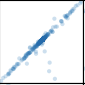 PKjwzrMWQv3Sm6mYKThbtK to PKgkfrXdHLYRslCZkvSy9m:

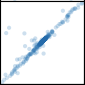 PKhJQ76WN3HvyN4JXjl4Kw to PKhGtfzBcvLh6qPtdBylJ5: 

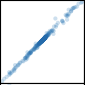 PKhJQ76WN3HvyN4JXjl4Kw to PKgkfrXdHLYRslCZkvSy9m: 

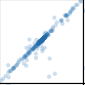 PKhGtfzBcvLh6qPtdBylJ5 to PKgkfrXdHLYRslCZkvSy9m: 



Reminder, Sim Tradespace is 


|'PKjwzrMWQv3Sm6mYKThbtK'| 'PKhJQ76WN3HvyN4JXjl4Kw'| 'PKhGtfzBcvLh6qPtdBylJ5'| 'PKgkfrXdHLYRslCZkvSy9m' |
| --- |--- |--- |--- |
|  LP33330 Baseline |  SAR-10237  |  SAR-10239  |  P33081  |

Plot the standard deviation of the Wildfire attitude error variable of the four simulations:

In [45]:
study_Wildfire_agents.blocks("root").attitudeError.study_stats()

count      mean       std       min   
PKjwzrMWQv3Sm6mYKThbtK attitudeError.0  999.0 -0.029148  0.518691 -3.042798  \
                       attitudeError.1  999.0 -0.025290  0.238541 -1.421243   
                       attitudeError.2  999.0  0.007253  0.419130 -2.854870   
PKhJQ76WN3HvyN4JXjl4Kw attitudeError.0  999.0 -0.031738  0.522620 -3.044003   
                       attitudeError.1  999.0 -0.020368  0.231197 -1.403003   
                       attitudeError.2  999.0  0.008327  0.417760 -2.856530   
PKhGtfzBcvLh6qPtdBylJ5 attitudeError.0  999.0 -0.028846  0.522901 -3.037756   
                       attitudeError.1  999.0 -0.025503  0.240353 -1.414298   
                       attitudeError.2  999.0  0.006952  0.426520 -2.856006   
PKgkfrXdHLYRslCZkvSy9m attitudeError.0  999.0 -0.036582  0.514280 -3.103202   
                       attitudeError.1  999.0 -0.020700  0.231167 -1.408989   
                       attitudeError.2  999.0  0.008063  0.414241 -2.854963   

                                             25%       50%       75%       max  
PKjwzrMWQv3Sm6mYKThbtK attitudeError.0 -0.014349 -0.003488 -0.000473  3.121786  
                       attitudeError.1 -0.014407 -0.008859 -0.004614  1.307353  
                       attitudeError.2 -0.017854 -0.015966  0.001056  3.038402  
PKhJQ76WN3HvyN4JXjl4Kw attitudeError.0 -0.014533 -0.003373 -0.000580  3.123206  
                       attitudeError.1 -0.013436 -0.008834 -0.002920  1.245555  
                       attitudeError.2 -0.017566 -0.015999  0.000718  3.045521  
PKhGtfzBcvLh6qPtdBylJ5 attitudeError.0 -0.014046 -0.003241 -0.000552  3.124569  
                       attitudeError.1 -0.014670 -0.009047 -0.004550  1.308999  
                       attitudeError.2 -0.017607 -0.015943  0.001075  3.113357  
PKgkfrXdHLYRslCZkvSy9m attitudeError.0 -0.014348 -0.003194 -0.000508  3.120662  
                       attitudeError.1 -0.013795 -0.008693 -0.002194  1.305868  
                       attitudeError.2 -0.018042 -0.016031  0.000594  3.089350

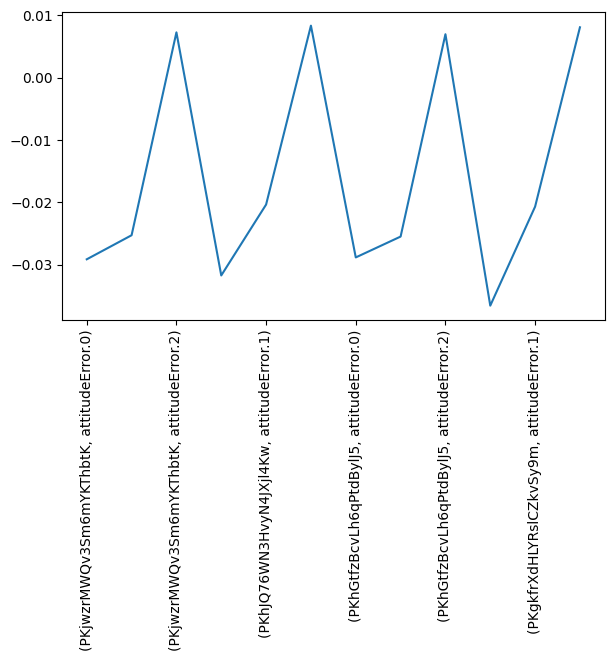

In [67]:
study_Wildfire_agents.blocks("root").attitudeError.study_stats()['mean'].plot(figsize=(7,4))
plt.xticks(rotation='vertical')
plt.show()

Which tells us the agent rolled more with  second(SAR-10237) and third(SAR-10239) batteries and the Agent with the P33081 rolled the least. 

*Note: The units are Radians which 0.520 radians = 30 degrees. The delta from the highest to the lowest is 0.008621 radians = 0.49 degrees*


We can look at how the roll differs at each time step between the simulations, however due to the different number of timesteps there will be misallignments
```
study_roll_df.T.describe().T
```





Next lets look at the attitude and commandedAttitude variables.

We'll need some helper functions to deal with quaternions. We'll use a np.array to hold the quaternion fields

In [40]:

from typing import TypeAlias
Quaternion: TypeAlias =  np.ndarray

# in python 3.12, you can use the type statement directly
# type Quaternion =  np.ndarray


def quaternionConjugate(quaternion):
    quaternionConj = np.array(-quaternion)
    quaternionConj[3] = -quaternionConj[3]

    return quaternionConj

def quaternionDot(q1, q2):
    '''
    REF 1: Eq. 2.82b, preserves the order of active rotation matrix multiplication
    '''
    return np.array([q1[3] * q2[0] + q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1],
                        q1[3] * q2[1] - q1[0] * q2[2] + q1[1] * q2[3] + q1[2] * q2[0],
                        q1[3] * q2[2] + q1[0] * q2[1] - q1[1] * q2[0] + q1[2] * q2[3],
                        q1[3] * q2[3] - q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2]])

def quaternionConjugate(quaternion):
    quaternionConj = np.array(-quaternion)
    quaternionConj[3] = -quaternionConj[3]

    return quaternionConj

def differenceQuaternion(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
    '''Calculate quaternion describing rotation from q1 to q2.

    Args:
        q1: Origin quaternion with shape (4,).
        q2: Destination quaternion with shape (4,).

    Returns:
        Quaternion with shape (4,).
    '''
    return quaternionDot(q1, quaternionConjugate(q2))

def angleBetweenQuaternion(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
    '''Calculate the angle between two quaternion attitudes.

    Args:
        q1: Quaternion with shape (4,).
        q2: Quaternion with shape (4,)

    Returns:
        Angle between the two quaternions, in radians.
    '''
    return 2 * np.arccos(min(abs(differenceQuaternion(q1, q2)[-1]), 1))

Lets take a quick look at the first simulations Wildfire attitude eci body and its commanded Attitude and compare the raw quaternion values 

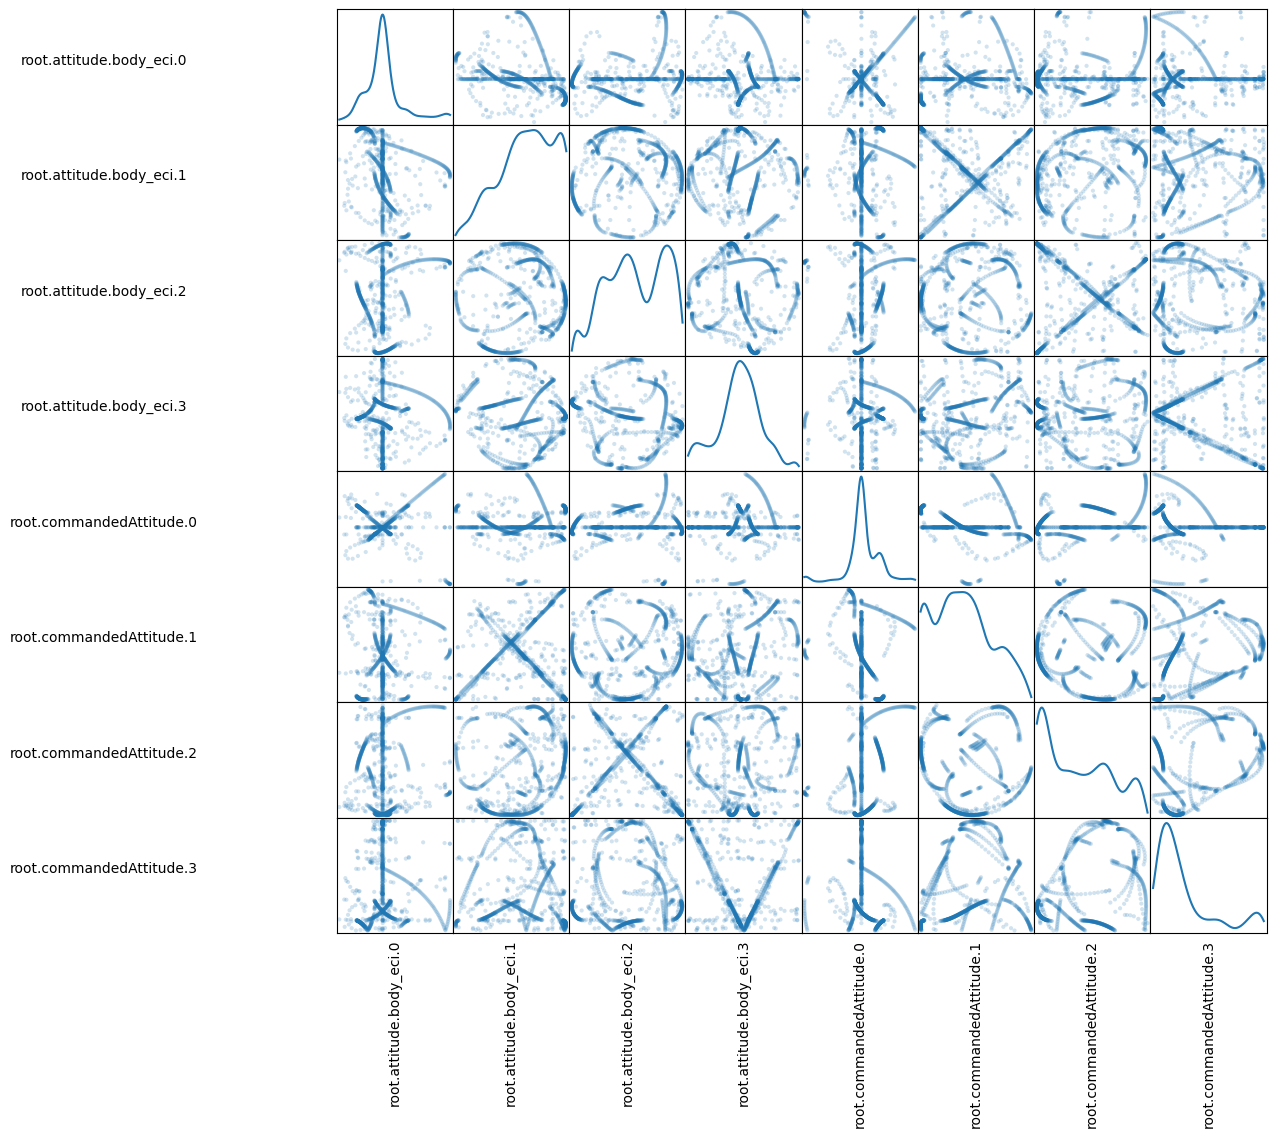

In [41]:
# use the folling to see the possible block.variable to filter on
#  Replace 
study_simjob_id = study_job_ids[0]
study_Wildfire_agents.sim_scatter_matrix('gnc',study_simjob_id, variables=['root.attitude.body_eci', 'root.commandedAttitude'])

Convert them into Quaterions

In [42]:
#Quaternion
simID_to_body_eci_quaternion = { sim_id: np.array(series.values) for (sim_id,series) in study_Wildfire_agents.blocks("root").attitude.body_eci.items() }

In [43]:
simID_to_body_eci_quaternion.keys()

dict_keys(['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m'])

Reminder, Sim Tradespace is 


|'PKjwzrMWQv3Sm6mYKThbtK'| 'PKhJQ76WN3HvyN4JXjl4Kw'| 'PKhGtfzBcvLh6qPtdBylJ5'| 'PKgkfrXdHLYRslCZkvSy9m' |
| --- |--- |--- |--- |
|  LP33330 Baseline |  SAR-10237  |  SAR-10239  |  P33081  |

In [44]:
battery_names = ['LP33330'  ,  'SAR-10237'  ,  'SAR-10239'  ,  'P33081']
tradespace = zip(battery_names, simID_to_body_eci_quaternion.keys())


Lets compare the stats results between Batteries pairs

In [45]:
import itertools

In [47]:
sim_ids_to_angleBetweenThem_series = { f"{left_name}::{right_name}": [angleBetweenQuaternion(s0, s1) for (s0, s1) in zip(simID_to_body_eci_quaternion[ left_id ], 
                                                                                simID_to_body_eci_quaternion[ right_id ])]
     for ( (left_name,left_id) , (right_name,right_id)) in itertools.combinations( list(tradespace), 2 )
      }

In [48]:
eci_deltas_df = pd.DataFrame(sim_ids_to_angleBetweenThem_series)

In [49]:
eci_deltas_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LP33330::SAR-10237,1000.0,0.019912,0.121677,0.0,0.001662,0.003840,0.009958,2.852099
LP33330::SAR-10239,1000.0,0.013637,0.038223,0.0,0.001574,0.003301,0.008601,0.507199
LP33330::P33081,1000.0,0.020085,0.125037,0.0,0.001594,0.003579,0.007342,2.885313
SAR-10237::SAR-10239,1000.0,0.021167,0.121125,0.0,0.001561,0.003321,0.007576,2.634443
SAR-10237::P33081,1000.0,0.012093,0.030408,0.0,0.001498,0.004653,0.008756,0.465640
SAR-10239::P33081,1000.0,0.022362,0.124988,0.0,0.001605,0.003581,0.007250,2.667821


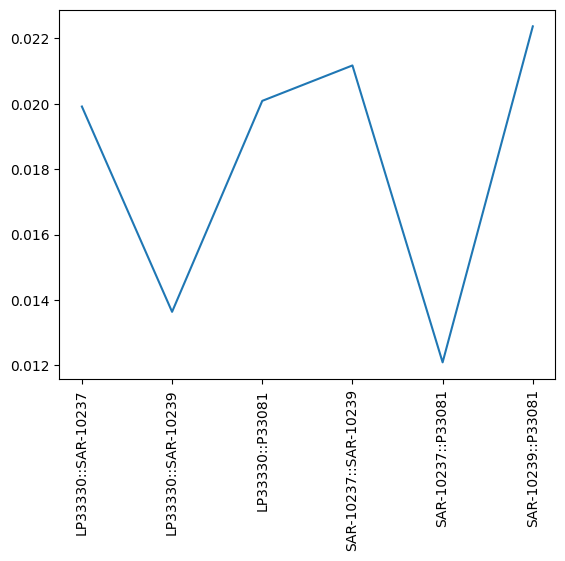

In [50]:
eci_deltas_df.describe().T['mean'].plot()
plt.xticks(rotation=90)
plt.show()

Do the same for commandedAttitude

In [57]:
study_Wildfire_agents.blocks("root").commandedAttitude.summarize()

---------------------------------------------------------------------------
                   Study Simulation Series Result Summary                  
                            'commandedAttitude'                            
                     Study ID: 'PKjwzmW99mRrRm4cmQGr7m'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m']
---------------------------------------------------------------------------
                    Study Simulation Series Data Summary                   
                            'commandedAttitude'                            
---------------------------------------------------------------------------
📈 sim_id:PKjwzrMWQv3Sm6mYKThbtK 1000 points covering 494.0 minutes with ~29.6s steps
📈 sim_id:PKhJQ76WN3HvyN4JXjl4Kw 1000 points cove

In [58]:
study_Wildfire_agents.blocks("root").commandedAttitude.study_stats()

,count,mean,std,min,25%,50%,75%,max
commandedAttitude.0,999.0,0.034760,0.200242,-0.735378,-3.780829e-17,1.614012e-17,0.123255,0.691208
commandedAttitude.1,999.0,-0.188859,0.556588,-0.972615,-6.165722e-01,-2.323345e-01,0.211864,0.956892
commandedAttitude.2,999.0,-0.265766,0.546600,-0.972573,-8.324426e-01,-3.011700e-01,0.160455,0.715465
commandedAttitude.3,999.0,0.380985,0.315332,0.002610,1.085759e-01,2.548347e-01,0.624629,0.999623


In [59]:
study_Wildfire_agents.blocks("root").commandedAttitude.values.items()

dict_items([('PKjwzrMWQv3Sm6mYKThbtK', Series(commandedAttitude)), ('PKhJQ76WN3HvyN4JXjl4Kw', Series(commandedAttitude)), ('PKhGtfzBcvLh6qPtdBylJ5', Series(commandedAttitude)), ('PKgkfrXdHLYRslCZkvSy9m', Series(commandedAttitude))])

In [60]:
simID_to_commandedAttitude_quaternion = { sim_id: np.array( [value for value in  series.values if value is not None]) for (sim_id,series) in study_Wildfire_agents.blocks("root").commandedAttitude.values.items() }

In [61]:
simID_to_commandedAttitude_quaternion.keys()

dict_keys(['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m'])

In [62]:
battery_names = ['LP33330'  ,  'SAR-10237'  ,  'SAR-10239'  ,  'P33081']
commandedAttitude_tradespace = zip(battery_names, simID_to_commandedAttitude_quaternion.keys())

In [63]:
sim_ids_to_commandedAttitude_angleBetweenThem_series = { f"{left_name}::{right_name}": [angleBetweenQuaternion(s0, s1) for (s0, s1) in zip(simID_to_body_eci_quaternion[ left_id ], 
                                                                                simID_to_body_eci_quaternion[ right_id ])]
     for ( (left_name,left_id) , (right_name,right_id)) in itertools.combinations( list(commandedAttitude_tradespace), 2 )
      }

In [64]:
commandedAttitude_deltas_df = pd.DataFrame(sim_ids_to_commandedAttitude_angleBetweenThem_series)

In [65]:
commandedAttitude_deltas_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LP33330::SAR-10237,1000.0,0.019912,0.121677,0.0,0.001662,0.003840,0.009958,2.852099
LP33330::SAR-10239,1000.0,0.013637,0.038223,0.0,0.001574,0.003301,0.008601,0.507199
LP33330::P33081,1000.0,0.020085,0.125037,0.0,0.001594,0.003579,0.007342,2.885313
SAR-10237::SAR-10239,1000.0,0.021167,0.121125,0.0,0.001561,0.003321,0.007576,2.634443
SAR-10237::P33081,1000.0,0.012093,0.030408,0.0,0.001498,0.004653,0.008756,0.465640
SAR-10239::P33081,1000.0,0.022362,0.124988,0.0,0.001605,0.003581,0.007250,2.667821


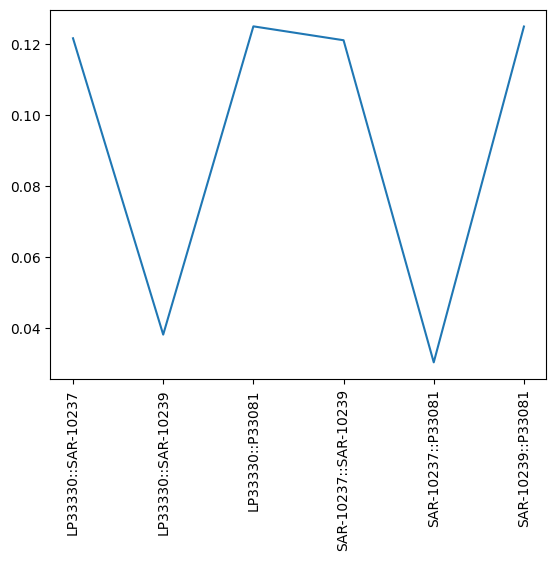

In [66]:
commandedAttitude_deltas_df.describe().T['std'].plot()
plt.xticks(rotation=90)
plt.show()

**Bonus section:**

A quick look at Fuel Tank deltas between the simulation

In [56]:
study_blocks2 = study_Wildfire_agents.blocksname('Fuel Tank')

In [57]:
study_blocks2.summarize()

---------------------------------------------------------------------------
                   Study Simulation Block Result Summary                   
                                'Fuel Tank'                                
                     Study ID: 'PKjwzmW99mRrRm4cmQGr7m'                    
---------------------------------------------------------------------------
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKjwzrMWQv3Sm6mYKThbtK', 'PKhJQ76WN3HvyN4JXjl4Kw', 'PKhGtfzBcvLh6qPtdBylJ5', 'PKgkfrXdHLYRslCZkvSy9m']
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📋 Variables Available
    • wetMass
    • activeDataMode
    • powerConsumed
    • dissipations
    • hotMargin
    • coldMargin
    • temperature
-----------------------

In [ ]:
study_blocks2.temperature['degC'].histogram

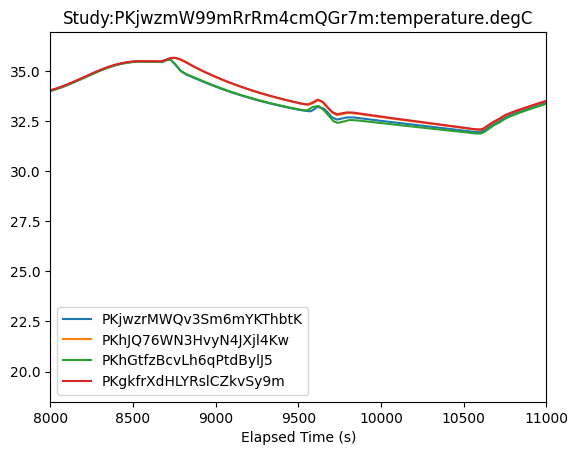

In [61]:
study_blocks2.temperature['degC'].plot(xlim=[8000,11000])